In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import skbio
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from statsmodels.nonparametric.smoothers_lowess import lowess
import scikit_posthocs as sp

run_type = "dry"
#run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"DR_lifelong":"red", "AL_lifelong":"dodgerblue", 
           "AL_DR16M":"teal", "AL_DR20M":"gold", "Food":"black"}
path = "../analysis/plots/alpha_beta_diversity/"

In [5]:
me = pd.read_csv("../metadata/metadata_F245_16S.csv", sep = ";")

In [6]:
# We have the alpha diversity values from estimate_richness in R
b = pd.read_csv("../analysis/intermediate/beta_values-melt_20210625.csv", sep = ";")
# Remove RDI==0 as that is a sample against itself
b = b[b["value"] != 0]
me["Biogroup"] = me["Months"].astype(str).str.replace('\.0', '') + "-" + me["Treatment"]

/Users/CMonzo/.conda/envs/MPI/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [7]:
b.drop(columns = ["index"], inplace = True)

b.columns = ["Sample_ID", "Sample_ID2", "value"]
# put it all together into a file
meb = pd.merge(me.loc[:, ["Sample_ID", "Biogroup"]], b, on = "Sample_ID")
meb.columns = ["Sample_ID1", "Biogroup_1", "Sample_ID", "value"]
meb = pd.merge(me.loc[:, ["Sample_ID", "Biogroup", "Treatment", "Months"]], meb, on = "Sample_ID")
meb.columns = ["Sample_ID2", "Biogroup_2", "Treatment", "Months", "Sample_ID1", "Biogroup_1", "value"]
df_prov = meb.loc[(meb['Biogroup_1'] == meb['Biogroup_2'])]

In [8]:
switch_corr = df_prov.copy()
switch_corr['Treatment'] = np.where((switch_corr['Treatment'] == 'AL_DR16M') & (switch_corr['Months'] < 15),
                      'Food',
                       switch_corr['Treatment'])
switch_corr['Treatment'] = np.where((switch_corr['Treatment'] == 'AL_DR20M') & (switch_corr['Months'] < 19),
                      'Food',
                       switch_corr['Treatment'])

/Users/CMonzo/.conda/envs/MPI/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/Users/CMonzo/.conda/envs/MPI/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


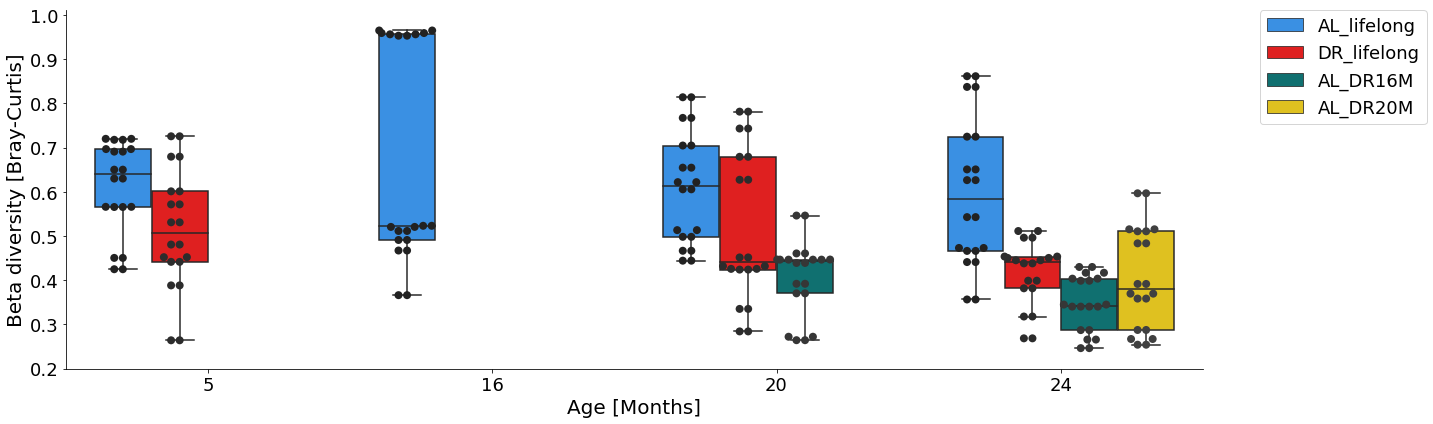

In [10]:
hue_order = ["AL_lifelong", "DR_lifelong", "AL_DR16M", "AL_DR20M"]
order = ["5", "16", "20", "24"]
fig, ax = plt.subplots(figsize = (20, 6))
ax = sns.boxplot(data = df_prov[df_prov["Treatment"] != "Food"], x = df_prov[df_prov["Treatment"] != "Food"]["Months"].astype(str).str.replace("\.0", ""), y = "value", 
                ax = ax, hue = "Treatment", palette = palette, showfliers = False, hue_order = hue_order, order = order)

ax = sns.swarmplot(data = df_prov[df_prov["Treatment"] != "Food"], x = df_prov[df_prov["Treatment"] != "Food"]["Months"].astype(str).str.replace("\.0", ""), y = "value", 
             color = ".25", hue = "Treatment", dodge = True, hue_order = hue_order, size = 8, ax = ax, order = order)
ax.tick_params(axis = "x", labelsize=18)
ax.tick_params(axis = "y", labelsize=18)
ax.set_xlabel("Age [Months]", fontsize = 20)
ax.set_ylabel("Beta diversity [Bray-Curtis]", fontsize = 20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 18)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()

if run_type != "dry":
    plt.savefig("{}Beta_boxplot_allDiets_{}.pdf".format(path, new_day))
else:
    plt.show()

In [11]:
def linreg_cond(text, df):
    if text == "DR_lifelong":
        color = "red"
        df_prov2 = df[df["Treatment"] == text]
        fig, ax = plt.subplots(figsize = (10, 5))
    elif text == "AL_lifelong":
        color = "dodgerblue"
        df_prov2 = df[df["Treatment"] == text]
        fig, ax = plt.subplots(figsize = (6.3, 5))
    elif text == "AL_DR16M":
        color = "teal"
        df_provA = df[df["Treatment"] == text]
        df_provA = df_provA[df_provA["Months"] > 14]
        df_provB = df[df["Treatment"] == "AL_lifelong"]
        df_provB = df_provB[df_provB["Months"] < 17]
        df_prov2 = pd.concat([df_provA, df_provB])
        fig, ax = plt.subplots(figsize = (7.8, 5))
    elif text == "AL_DR20M":
        color = "gold"
        df_provA = df[df["Treatment"] == text]
        df_provA = df_provA[df_provA["Months"] > 18]
        df_provB = df[df["Treatment"] == "AL_lifelong"]
        df_provB = df_provB[df_provB["Months"] < 21]
        df_prov2 = pd.concat([df_provA, df_provB])
        fig, ax = plt.subplots(figsize = (5.8, 5))
    sns.regplot(data = df_prov2, x = "Months", 
              y = "value", scatter_kws = {"s":3, "color":"lightgrey"}, line_kws = {"color":color},
               x_jitter = 0.3)

    plt.title(text, fontsize = 20)

    ax.tick_params(axis = "x", labelsize=18)
    ax.tick_params(axis = "y", labelsize=18)
    ax.set_xlabel("Age [Months]", fontsize = 20)
    ax.set_ylabel("Beta diversity [Bray-Curtis]", fontsize = 20)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    
    # Linear regression
    x = df_prov2.Months.to_list()
    y = df_prov2.value.to_list()
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f"\nLinear regression for beta diversity: {text}")
    print(f"Slope: {slope}\nIntercept: {intercept}\np-value: {p_value}\nstd_err: {std_err}")
    

    if run_type != "dry":
        plt.savefig("{}Beta_linreg_{}_{}.pdf".format(path, text, new_day))
    else:
        plt.show()


Linear regression for beta diversity: DR_lifelong
Slope: -0.00363096853761941
Intercept: 0.5418321199828522
p-value: 0.09691628495506009
std_err: 0.0021519336952761908

Linear regression for beta diversity: AL_lifelong
Slope: -0.0006247381717430819
Intercept: 0.6323424469323651
p-value: 0.8154673127666386
std_err: 0.002667894043016678

Linear regression for beta diversity: AL_DR16M
Slope: -0.014043011888117369
Intercept: 0.7376231791342396
p-value: 1.1590743089625405e-06
std_err: 0.0026624682104940214

Linear regression for beta diversity: AL_DR20M
Slope: -0.00813501114387332
Intercept: 0.7057493085631863
p-value: 0.004668169134105631
std_err: 0.002792699954026688


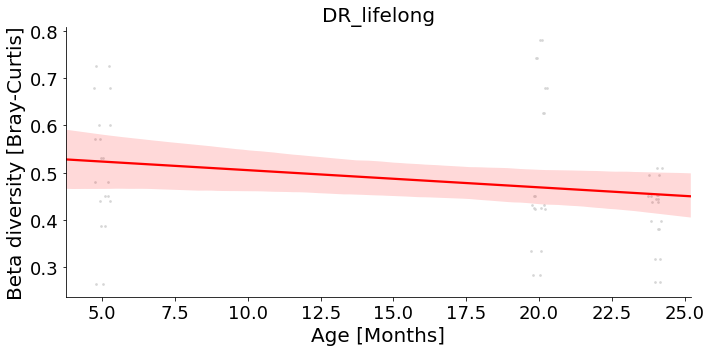

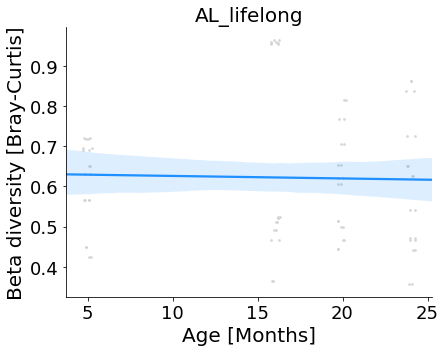

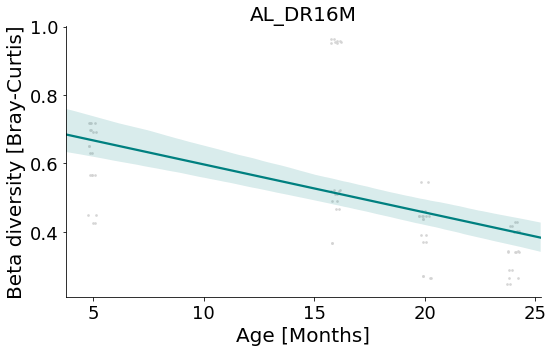

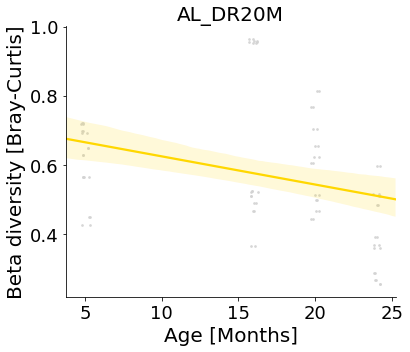

In [12]:
linreg_cond("DR_lifelong", df_prov[df_prov["Months"] < 25])
linreg_cond("AL_lifelong", df_prov[df_prov["Months"] < 25])
linreg_cond("AL_DR16M", df_prov[df_prov["Months"] < 25])
linreg_cond("AL_DR20M", df_prov[df_prov["Months"] < 25])

In [9]:
print("//ANOVA BETWEEN TREATMENTS WITHIN TIMEPOINTS//")
# Check ANOVA between treatments within timepoints
pd.set_option("display.max_rows", None, "display.max_columns", None)
for e in [5, 20, 24]:
    
    print("Anova comparing treatments at {} Months \n".format(e))

    test = df_prov[df_prov["Months"] == e]
    mod = ols("value ~ 0 + Treatment", data = test).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

    pair_t = mod.t_test_pairwise("Treatment", method = "Bonferroni")
    print(pd.DataFrame(pair_t.result_frame))

//ANOVA BETWEEN TREATMENTS WITHIN TIMEPOINTS//
Anova comparing treatments at 5 Months 

              sum_sq    df           F        PR(>F)
Treatment  12.737784   2.0  440.159106  5.236216e-27
Residual    0.549842  38.0         NaN           NaN
                             coef   std err        t     P>|t|  \
DR_lifelong-AL_lifelong -0.097645  0.038039 -2.56697  0.014321   

                         Conf. Int. Low  Conf. Int. Upp.  pvalue-Bonferroni  \
DR_lifelong-AL_lifelong        -0.17465        -0.020639           0.014321   

                         reject-Bonferroni  
DR_lifelong-AL_lifelong               True  
Anova comparing treatments at 20 Months 

              sum_sq    df           F        PR(>F)
Treatment  16.117910   3.0  312.278536  2.466699e-35
Residual    0.980664  57.0         NaN           NaN
                             coef   std err         t     P>|t|  \
AL_lifelong-AL_DR16M     0.200509  0.041478  4.834040  0.000011   
DR_lifelong-AL_DR16M     0.109849  0

In [10]:
print("//Kruskall-Wallis BETWEEN TREATMENTS WITHIN TIMEPOINTS//")
# Check ANOVA between treatments within timepoints
pd.set_option("display.max_rows", None, "display.max_columns", None)
for e in [5, 20, 24]:
    
    print("Kruskall-Wallis comparing treatments at {} Months\n".format(e))

    test = df_prov[df_prov["Months"] == e]
    print(stats.kruskal(test["value"].to_list(), test["Treatment"].to_list()))
    print("Mann-Whitney comparing treatments at {} Months \n".format(e))
    print(sp.posthoc_dunn(test, val_col = "value", group_col = "Treatment", p_adjust = 'bonferroni'))

//Kruskall-Wallis BETWEEN TREATMENTS WITHIN TIMEPOINTS//
Kruskall-Wallis comparing treatments at 5 Months

KruskalResult(statistic=61.18102613746374, pvalue=5.206084353216e-15)
Mann-Whitney comparing treatments at 5 Months 

             AL_lifelong  DR_lifelong
AL_lifelong     1.000000     0.039615
DR_lifelong     0.039615     1.000000
Kruskall-Wallis comparing treatments at 20 Months

KruskalResult(statistic=90.51979151993238, pvalue=1.831358328537702e-21)
Mann-Whitney comparing treatments at 20 Months 

             AL_DR16M  AL_lifelong  DR_lifelong
AL_DR16M     1.000000     0.000067     0.193937
AL_lifelong  0.000067     1.000000     0.050388
DR_lifelong  0.193937     0.050388     1.000000
Kruskall-Wallis comparing treatments at 24 Months

KruskalResult(statistic=120.198440822112, pvalue=5.72387239637245e-28)
Mann-Whitney comparing treatments at 24 Months 

                 AL_DR16M  AL_DR20M   AL_lifelong  DR_lifelong
AL_DR16M     1.000000e+00   0.40897  4.913287e-07     0.099554

In [11]:
# Now comparing between ages of the same diet
# Statistics
print("//K-W BETWEEN TIMEPOINTS WITHIN DIETS//")

meax = df_prov[df_prov["Months"] < 25]

# Check ANOVA between treatments within timepoints
pd.set_option("display.max_rows", None, "display.max_columns", None)
for e in ["AL_lifelong", "DR_lifelong", "AL_DR16M", "AL_DR20M"]:
    
    print("Kruskall-Wallis comparing timepoints of {} diet\n".format(e))

    test = meax[meax["Treatment"] == e]

    print(stats.kruskal(test["value"].to_list(), test["Months"].to_list()))
    print("Mann-Whitney comparing timepoints of {} diet\n".format(e))
    print(sp.posthoc_dunn(test, val_col = "value", group_col = "Months", p_adjust = 'bonferroni'))



//K-W BETWEEN TIMEPOINTS WITHIN DIETS//
Kruskall-Wallis comparing timepoints of AL_lifelong diet

KruskalResult(statistic=120.198440822112, pvalue=5.72387239637245e-28)
Mann-Whitney comparing timepoints of AL_lifelong diet

     5    16   20   24
5   1.0  1.0  1.0  1.0
16  1.0  1.0  1.0  1.0
20  1.0  1.0  1.0  1.0
24  1.0  1.0  1.0  1.0
Kruskall-Wallis comparing timepoints of DR_lifelong diet

KruskalResult(statistic=90.51979151993238, pvalue=1.831358328537702e-21)
Mann-Whitney comparing timepoints of DR_lifelong diet

          5         20        24
5   1.000000  1.000000  0.081317
20  1.000000  1.000000  0.332745
24  0.081317  0.332745  1.000000
Kruskall-Wallis comparing timepoints of AL_DR16M diet

KruskalResult(statistic=61.18102613746374, pvalue=5.206084353216e-15)
Mann-Whitney comparing timepoints of AL_DR16M diet

          20        24
20  1.000000  0.006778
24  0.006778  1.000000
Kruskall-Wallis comparing timepoints of AL_DR20M diet

KruskalResult(statistic=33.47639484978542,

ZeroDivisionError: float division by zero